In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import matplotlib

In [44]:
# %matplotlib widget
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from calendar import month_name, month_abbr

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr
from cartopy import crs as ccrs

### plotting 
from matplotlib import pyplot as plt
import palettable

In [45]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

### import local functions for the downloading of the C3S forecasts 

In [46]:
sys.path.append('../..')

In [47]:
from ICU_Water_Watch import geo, C3S, domains, plot

### EEZ shapes 

In [48]:
dpath_shapes = HOME.joinpath('operational/ICU/development/hotspots/data/shapefiles')

In [49]:
EEZs, merged_EEZs = geo.get_EEZs(dpath_shapes)

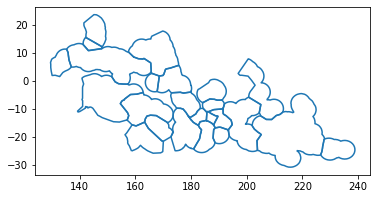

In [50]:
EEZs.boundary.plot(); 

### year and month (initial month of the forecast)

In [51]:
year = 2021

In [52]:
month = 5

### read the probabilistic forecasts from the GCMs now 

#### list of GCMs to inlude 

In [53]:
list_GCMs = ['ECMWF','UKMO','METEO_FRANCE','CMCC','DWD', 'NCEP', 'JMA', 'ECCC']

#### period (`monthly` or `seasonal`)

In [54]:
period = 'monthly'

#### quantiles (`tercile`, `decile`, `percentile`, with the latest including categories defined by quantile 0.02 (2%) and then 0.05 to 0.95 with 0.05 increment)

In [55]:
quantile = 'percentile'

### variable 

In [56]:
varname = 'precip'

### domain 

In [57]:
domains.domains

{'Tropical_Pacific': [140, 220, -25, 25],
 'SW_Pacific': [172.5, 190, -22.5, -12],
 'Fiji': [175, 183, -21, -15],
 'NZ': [161, 181, -50, -30],
 'Pacific': [140, 240, -50, 25],
 'C3S_download': [140, 240, -50, 30],
 'Water_Watch': [120, 240, -38, 22.5]}

In [58]:
domain = 'Water_Watch'

### paths to the realtime forecasts

In [59]:
dpath_forecasts = CWD.parents[1].joinpath("outputs/C3S")

In [60]:
lfiles = list(dpath_forecasts.glob(f"{period}_{quantile}s_probabilities_from_{year}-{str(month).zfill(2)}_*.netcdf"))

In [61]:
[f.name for f in lfiles]

['monthly_percentiles_probabilities_from_2021-05_ECCC.netcdf',
 'monthly_percentiles_probabilities_from_2021-05_CMCC.netcdf',
 'monthly_percentiles_probabilities_from_2021-05_NCEP.netcdf',
 'monthly_percentiles_probabilities_from_2021-05_UKMO.netcdf',
 'monthly_percentiles_probabilities_from_2021-05_DWD.netcdf',
 'monthly_percentiles_probabilities_from_2021-05_JMA.netcdf',
 'monthly_percentiles_probabilities_from_2021-05_ECMWF.netcdf',
 'monthly_percentiles_probabilities_from_2021-05_METEO_FRANCE.netcdf']

### open the multiple files dataset, concatenate along the "GCM" dimension 

In [62]:
probs = xr.open_mfdataset(lfiles, concat_dim='GCM', engine='netcdf4') 

In [63]:
probs

,Array,Chunk
Bytes,69.44 MiB,8.68 MiB
Shape,"(8, 21, 1, 5, 86, 126)","(1, 21, 1, 5, 86, 126)"
Count,24 Tasks,8 Chunks
Type,float64,numpy.ndarray


### look at the sum for each GCM, should sum to 100 

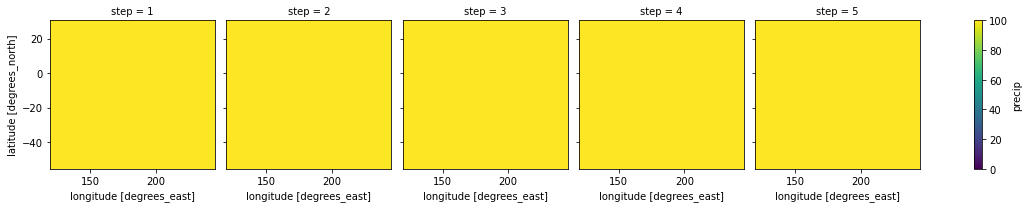

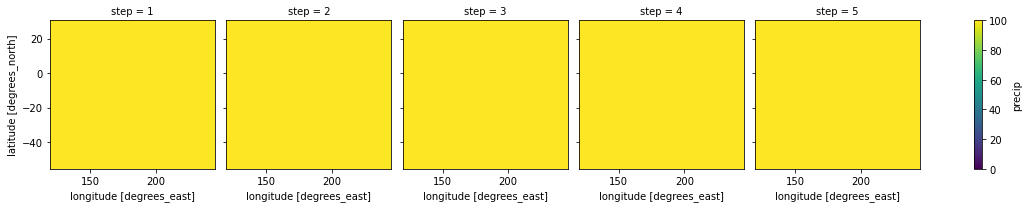

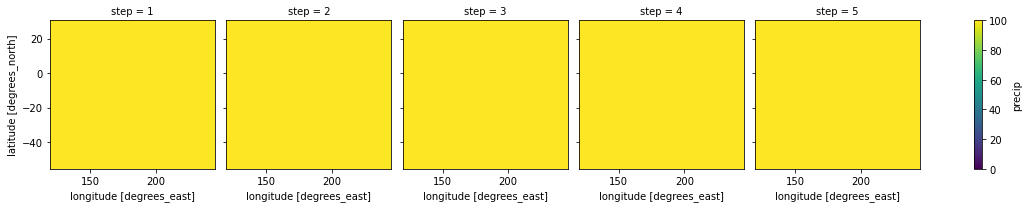

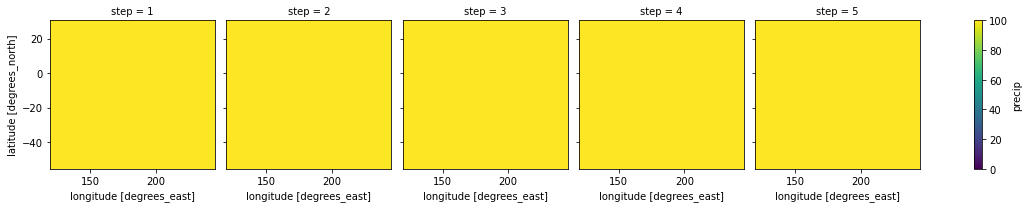

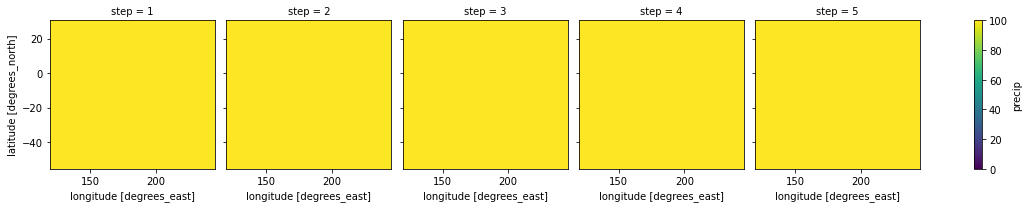

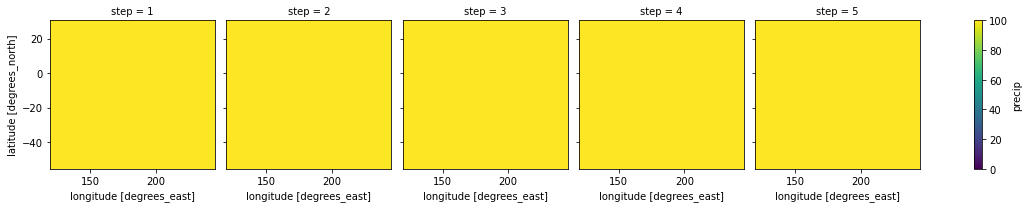

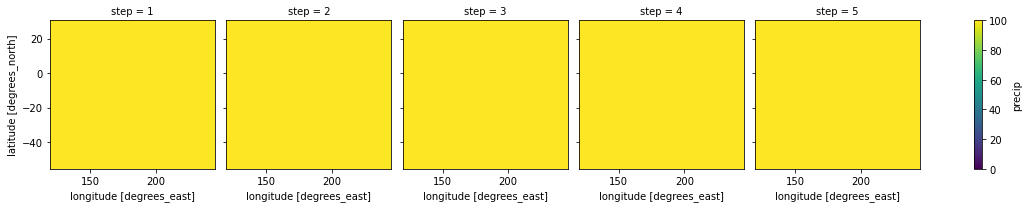

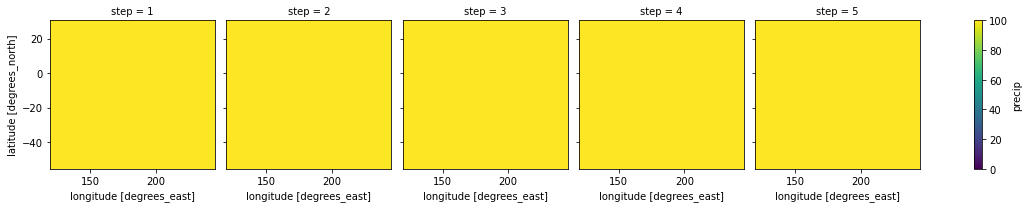

In [64]:
for GCM in probs.GCM:
    _ = probs.sel(GCM=GCM).sum(quantile).squeeze()[varname].plot(col='step', vmin=0);

### calculates the average across the GCM dimension 

In [65]:
probs_mean = probs.mean('GCM')

### because of numerical approximations, the sum can sometimes be slightly over 100 (the errors can accumulate over all the dimensions)

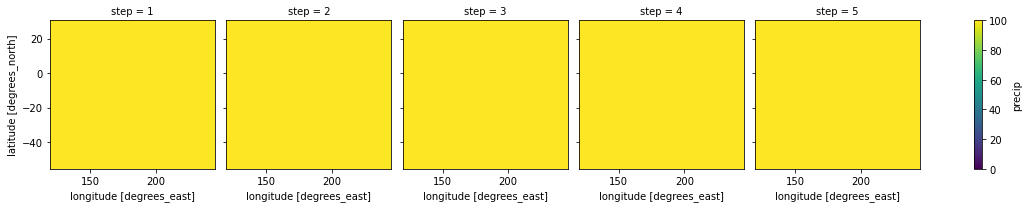

In [66]:
_ = probs_mean.sum(quantile).squeeze()[varname].plot(col='step', vmin=0)

### so we rescale (just in case)

In [67]:
probs_mean = (probs_mean / probs_mean.sum(quantile)) * 100

### because the attributes are lost during these operations, we add them back 

In [68]:
probs_mean.attrs = probs.attrs

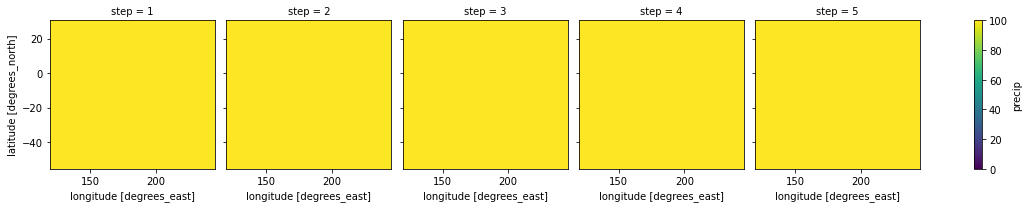

In [69]:
_ = probs_mean.sum(quantile).squeeze()['precip'].plot(col='step', vmin=0)

### Probability for being below a given percentile

#### choose the percentile here 

In [70]:
pmax = 25

### generate the percentile bins, and select the category (which start at 1) that corresponds to the bin with right edge at `pmax`

In [71]:
probs_mean.attrs

{'pct_values': array([0.02, 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])}

In [72]:
percentile_bins = probs_mean.attrs['pct_values']

In [73]:
percentile_bins

array([0.02, 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [74]:
max_cat = np.digitize(pmax/100, percentile_bins)

In [75]:
max_cat

6

### plots the probabilities 

In [76]:
cmap = palettable.scientific.sequential.Bilbao_20.mpl_colormap

In [77]:
domain = domains.domains['Water_Watch']

### cumulative probability over the percentile dimension 

In [78]:
cumulative_probs = probs_mean.cumsum(dim=quantile)

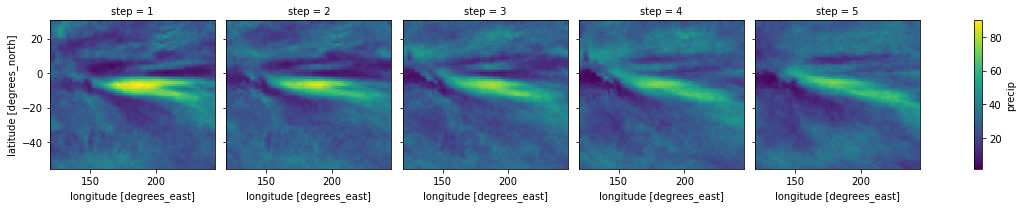

In [79]:
_ = cumulative_probs.sel({quantile:max_cat})[varname].squeeze().plot(col='step')

### plot the probabilities for rainfall being below the climatological 25th percentile, for the next 3 months period  

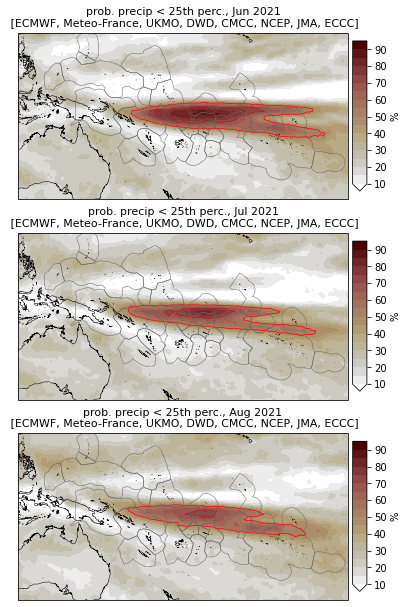

In [80]:
f = plot.map_MME_probabilities(probs_mean, nsteps=3, pct=pmax, domain=domain, shape=EEZs, pct_dim=quantile)

### probability for rainfall accumulation being below the median (50th percentile), for the next 5 months period

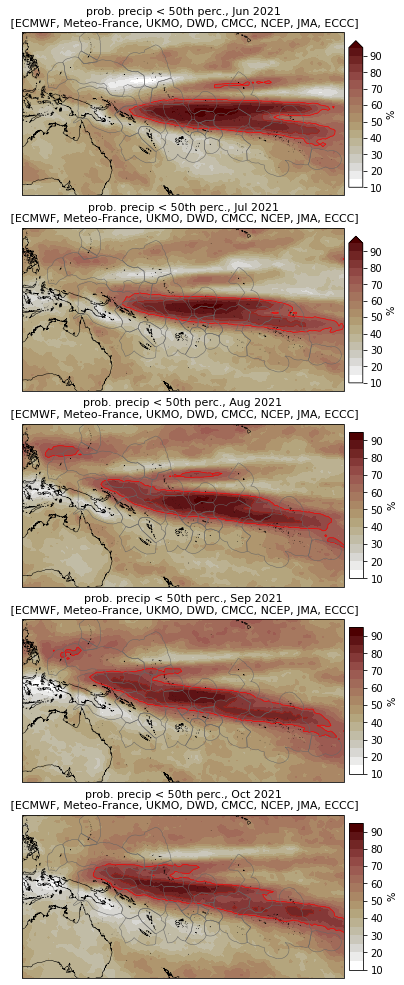

In [82]:
f = plot.map_MME_probabilities(probs_mean, nsteps=5, pct=50, domain=domain, shape=EEZs, pct_dim=quantile, contours=[70, 80])

### probability for rainfall accumulation being above the median (50th percentile)

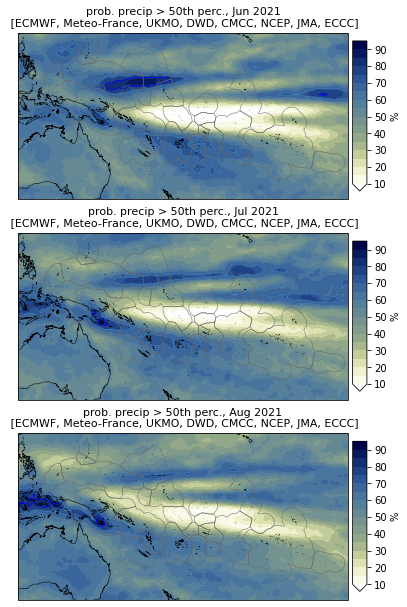

In [83]:
f = plot.map_MME_probabilities(probs_mean, nsteps=3, pct=50, comp='above', domain=domain, shape=EEZs, pct_dim=quantile, contours=[70, 80],  contours_colors=['steelblue', 'b'])

### probability for rainfall accumulation being above the 70th percentile

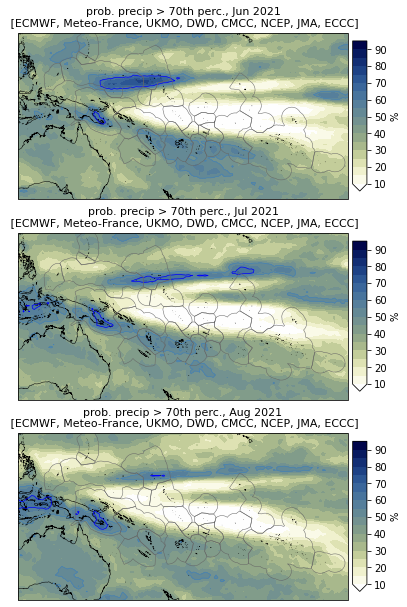

In [84]:
f = plot.map_MME_probabilities(probs_mean, nsteps=3, pct=70, comp='above', domain=domain, shape=EEZs, contours=[70, 80], contours_colors=['steelblue', 'b'])